<a href="https://colab.research.google.com/github/radhika1112/Reddit-Data-Analysis-and-Prediction/blob/master/Subredit_and_discourse_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A: Subreddit Prediction ##

In [0]:
subreddit_train = "coursework_subreddit_train.json"
subreddit_test = "coursework_subreddit_test.json"

!gsutil cp gs://textasdata/coursework/coursework_subreddit_train.json $subreddit_train 
!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

Copying gs://textasdata/coursework/coursework_subreddit_train.json...
/ [1 files][ 10.1 MiB/ 10.1 MiB]                                                
Operation completed over 1 objects/10.1 MiB.                                     
Copying gs://textasdata/coursework/coursework_subreddit_test.json...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


##  Preprocessing 


### 1. Read Train data

In [0]:
import pandas as pd
import numpy as np
train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
print(list(train_threads.columns.values))
print(train_threads.head())
print(train_threads.size)

print(train_threads.posts[0])

['is_self_post', 'posts', 'subreddit', 'title', 'url']
   is_self_post                                              posts  \
0           1.0  [{'body': 'I think everyone has that one frien...   
1           1.0  [{'body': 'I not 100% sure this is the right p...   
2           1.0  [{'body': '', 'author': 'Leisure321', 'url': '...   
3           1.0  [{'body': 'It's called 'forgetting things'.', ...   
4           1.0  [{'body': 'How would I do this? I am looking t...   

        subreddit                                              title  \
0   relationships  How do I [23F] communicate with my self-center...   
1  summonerschool  What Cherry switch do you recommend for League...   
2       askreddit                   Where do memes go when they die?   
3           trees                     Some weird long term affects??   
4        buildapc  Simple question: If I install Windows to a sta...   

                                                 url  
0  https://www.reddit.com/r/relation

### 2. Read Test Data

In [0]:
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
print(test_threads.head())
print(test_threads.size)

   is_self_post                                              posts  \
0           1.0  [{'body': 'Was watching a VOD from last years ...   
1           1.0  [{'body': 'Basically what the title says.', 'u...   
2           1.0  [{'body': '', 'author': 'Daft-Punk', 'url': 'h...   
3           1.0  [{'body': 'I start running this year. I do it ...   
4           1.0  [{'body': '[deleted]', 'url': 'https://www.red...   

       subreddit                                              title  \
0      starcraft  Just a reminder on how much SC2 has evolved th...   
1    whowouldwin  Your Favorite Hero Now Has A Healing Factor As...   
2      askreddit  If you could live anywhere in the world, where...   
3      askreddit                   Do you ever get use to exercise?   
4  tipofmytongue         [TOMT] [book] A scary french book for kids   

                                                 url  
0  https://www.reddit.com/r/starcraft/comments/mq...  
1  https://www.reddit.com/r/whowouldwin/co

In [0]:
subreddit_counts = train_threads['subreddit'].value_counts()
print(subreddit_counts.describe())
top_subbreddits = subreddit_counts.nlargest(20)
top_subbreddits_list = top_subbreddits.index
print(top_subbreddits)

count     20.000000
mean      72.800000
std       73.368285
min       28.000000
25%       36.250000
50%       45.500000
75%       63.750000
max      334.000000
Name: subreddit, dtype: float64
askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
pcmasterrace             62
gaming                   62
electronic_cigarette     59
relationships            48
tipofmytongue            43
jailbreak                38
hearthstone              38
atheism                  37
summonerschool           37
reddit.com               34
movies                   33
whowouldwin              33
personalfinance          32
starcraft                28
Name: subreddit, dtype: int64


In [0]:
train_labels = train_threads['subreddit']
test_labels = test_threads['subreddit']

In [0]:
import spacy

# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list
import nltk
nltk.download('stopwords')

    100% |████████████████████████████████| 120.9MB 96.6MB/s 
  Running setup.py install for en-core-web-md ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords as stpwrds

stopwords = set(stpwrds.words('english'))

### 3. Tokenize and normalize

In [0]:
#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
   # if token.text not in stopwords: 
       tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

### 4. Adding Body and Author ID as a feature

In [0]:
def getBody(posts):
  arr= list()
   
  for post in posts:
    try:
      arr.append(post['body'])
    except KeyError:
      pass
    
  return ''.join(map(str, arr))


def getAuthor(posts):
  arr= list()
   
  for post in posts:
    try:
      arr.append(post['author'])
    except KeyError:
      pass
    
  return ''.join(map(str, arr))


# #train_threads.title
# new_frame = pd.DataFrame()
# new_frame['Len'] = train_threads.Body.apply(getBodylen)
# new_frame['Body'] = train_threads.Body
# new_frame



In [0]:
train_threads['Body'] = train_threads.posts.apply(getBody)
#print(train_threads['Body'])
test_threads['Body'] = test_threads.posts.apply(getBody)


train_threads['Author']= train_threads.posts.apply(getAuthor)
test_threads['Author'] = test_threads.posts.apply(getAuthor)


print(train_threads.posts[0])

[{'body': 'I think everyone has that one friend who loves to hear themselves talk. If it\'s worth it to you to keep Hannah is your life, try a different approach.\n\nIf you need to talk about something important that requires her full attention, make some serious eye contact and say something to the effect of "Hannah, I truly value your opinion and need your help. I need to speak with you about something near dear to me. Can I have your full attention and advise about this?" She will hopefully understand the gravity of what you are asking. \n\nIf not, it may be time to part way amicably before things get nasty.\n\nGood luck!', 'post_depth': 1, 'author': 'Pouritdownmythroat', 'majority_link': 't3_2x19a2', 'annotations': [{'main_type': 'answer', 'link_to_post': 't3_2x19a2', 'annotator': '343090f214e68ce7f8a0c4111d6022ec'}, {'main_type': 'answer', 'link_to_post': 't3_2x19a2', 'annotator': 'd0bf500c45ae7c1c08eb65ef0a4e48f9'}, {'main_type': 'answer', 'link_to_post': 't3_2x19a2', 'annotator'

In [0]:
#for post in train_threads.posts[0]:
 # print(post)
#print(*train_threads.posts.iloc[0],sep="\n")
train_threads.posts.iloc[0]
#train_threads[np.logical_and(train_threads.subreddit=='askreddit', train_threads.posts['majority_type']=='')]

[{'annotations': [{'annotator': '343090f214e68ce7f8a0c4111d6022ec',
    'link_to_post': 't3_2x19a2',
    'main_type': 'answer'},
   {'annotator': 'd0bf500c45ae7c1c08eb65ef0a4e48f9',
    'link_to_post': 't3_2x19a2',
    'main_type': 'answer'},
   {'annotator': 'e9e4b3ab355135fa954badcc06bfccc6',
    'link_to_post': 't3_2x19a2',
    'main_type': 'answer'}],
  'author': 'Pouritdownmythroat',
  'body': 'I think everyone has that one friend who loves to hear themselves talk. If it\'s worth it to you to keep Hannah is your life, try a different approach.\n\nIf you need to talk about something important that requires her full attention, make some serious eye contact and say something to the effect of "Hannah, I truly value your opinion and need your help. I need to speak with you about something near dear to me. Can I have your full attention and advise about this?" She will hopefully understand the gravity of what you are asking. \n\nIf not, it may be time to part way amicably before things 

In [0]:

#print(*train_threads.posts.iloc[0],sep="\n")

try:
  print(train_threads['subreddits'])
except KeyError:
  pass

## Question 1: 

One Hot Encoding

In [0]:

from sklearn.feature_extraction.text import CountVectorizer

from scipy import sparse


one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize,binary=True)
train_features_onehot_body =one_hot_vectorizer.fit_transform(train_threads['Body'])
test_features_onehot_body = one_hot_vectorizer.transform(test_threads['Body'])


train_features_onehot_auth =one_hot_vectorizer.fit_transform(train_threads['Author'])
test_features_onehot_auth = one_hot_vectorizer.transform(test_threads['Author'])


train_features_onehot_title =one_hot_vectorizer.fit_transform(train_threads['title'])
test_features_onehot_title = one_hot_vectorizer.transform(test_threads['title'])

train_features_onehot =sparse.hstack([train_features_onehot_body,train_features_onehot_auth,train_features_onehot_title])

test_features_onehot = sparse.hstack([test_features_onehot_body,test_features_onehot_auth,test_features_onehot_title])

In [0]:
# Tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,binary=True)
# train_features_tf_b =Tfidf_vectorizer.fit_transform(train_threads['Body'])
# test_features_tf_b = Tfidf_vectorizer.transform(test_threads['Body'])

TFIDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy import sparse


Tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,binary=True)
train_features_tf_b =Tfidf_vectorizer.fit_transform(train_threads['Body'])
test_features_tf_b = Tfidf_vectorizer.transform(test_threads['Body'])


train_features_tf_a =Tfidf_vectorizer.fit_transform(train_threads['Author'])
test_features_tf_a = Tfidf_vectorizer.transform(test_threads['Author'])


train_features_tf_t =Tfidf_vectorizer.fit_transform(train_threads['title'])
test_features_tf_t = Tfidf_vectorizer.transform(test_threads['title'])


train_features_tfidf = sparse.hstack([train_features_tf_b,train_features_tf_a,train_features_tf_t])

# train_features_tfidf = sparse.hstack([train_features_tf_b,train_features_tf_a,train_features_tf_t,
#                                       sparse.csr_matrix(train_threads["bodylen"].reshape(-1, 1))])
test_features_tfidf = sparse.hstack([test_features_tf_b,test_features_tf_a, test_features_tf_t])

## Logistic Regression 

### One hot Encoded

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Evaluation for: One-hot LR
Classifier 'One-hot LR' has Acc=0.690 P=0.587 R=0.757 F1=0.622
                      precision    recall  f1-score   support

           askreddit      0.905     0.679     0.776       112
             atheism      0.500     0.857     0.632         7
            buildapc      0.784     0.806     0.795        36
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.714     0.588     0.645        17
              gaming      0.412     0.389     0.400        18
         hearthstone      0.467     1.000     0.636         7
           jailbreak      0.545     0.667     0.600         9
     leagueoflegends      0.896     0.614     0.729        70
              movies      0.400     1.000     0.571         2
        pcmasterrace      0.348     0.727     0.471        11
     personalfinance      0.900     1.000     0.947         9
          reddit.com      0.000     0.000     0.000         0
       relationships      1.000     1.000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


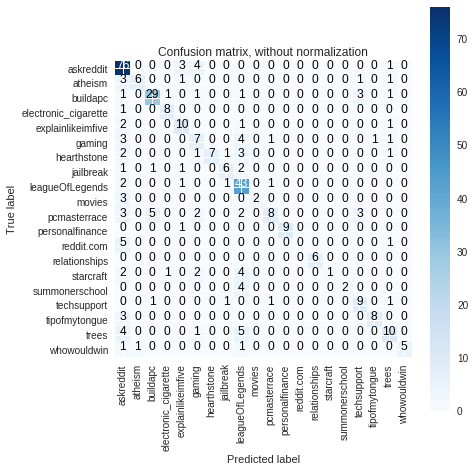

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))


def evaluation_summary_full(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))


classifier = LogisticRegression()
nb_model = classifier.fit(train_features_onehot, train_labels)
predicted_label_lr = nb_model.predict(test_features_onehot)
evaluation_summary_grid("One-hot LR",  predicted_label_lr, test_labels)

### TFIDF

In [0]:
classifier = LogisticRegression()
nb_model = classifier.fit(train_features_tfidf, train_labels)
predicted_label_lr = nb_model.predict(test_features_tfidf)
evaluation_summary_full("LR tfidf",  predicted_label_lr, test_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Evaluation for: LR tfidf
Classifier 'LR tfidf' has Acc=0.551 P=0.352 R=0.598 F1=0.380

Confusion matrix:
 [[83  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0 29  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1]
 [ 3  0  1  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  2  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0  1  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  1  0]
 [ 5  0  0  0  0  0  0  3  1  0  1  0  0  0  0  0  1  0  0  0]
 [ 4  0  0  0  0  0  0  0 43  0  1  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  0  6  0  0  0  0  0  7  0  2  0  0  0  0  0  1  0  0  0]
 [ 3  0  1  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 3  0  0  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## SVC 

###One hot encoded

In [0]:
from sklearn.svm import SVC

classifier = SVC(gamma='auto',kernel='rbf')
nb_model = classifier.fit(train_features_onehot, train_labels)
predicted_label_lr = nb_model.predict(test_features_onehot)
evaluation_summary("One-hot SVC",  predicted_label_lr, test_labels)

Evaluation for: One-hot SVC
Classifier 'One-hot SVC' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships      0.000     0.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### TFIDF

In [0]:
from sklearn.svm import SVC
classifier = SVC(gamma='auto',kernel='rbf')
nb_model = classifier.fit(train_features_tfidf, train_labels)
predicted_label_lr = nb_model.predict(test_features_tfidf)
evaluation_summary("FTIDF SVC",  predicted_label_lr, test_labels)

Evaluation for: FTIDF SVC
Classifier 'FTIDF SVC' has Acc=0.230 P=0.050 R=0.012 F1=0.019
                      precision    recall  f1-score   support

           askreddit      1.000     0.230     0.374       365
             atheism      0.000     0.000     0.000         0
            buildapc      0.000     0.000     0.000         0
electronic_cigarette      0.000     0.000     0.000         0
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.000     0.000     0.000         0
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships      0.000     0.000  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Dummy Classifier 
For both Strategies

1. Stratified
2. Most_frequent

### One Hot encoded

In [0]:
from sklearn.dummy import DummyClassifier


classifier1=DummyClassifier(strategy="stratified")
classifier2=DummyClassifier(strategy="most_frequent")
                            
Dummy_model1 = classifier1.fit(train_features_onehot, train_labels)
Dummy_model2 = classifier2.fit(train_features_onehot, train_labels)


predicted_label_dummy1 = Dummy_model1.predict(test_features_onehot)
predicted_label_dummy2 = Dummy_model2.predict(test_features_onehot)

            
evaluation_summary(" Dummy Classifier with stratifed",  predicted_label_dummy1, test_labels)
evaluation_summary("Dummy Classifier with most_frequent",  predicted_label_dummy2, test_labels)

Evaluation for:  Dummy Classifier with stratifed
Classifier ' Dummy Classifier with stratifed' has Acc=0.088 P=0.042 R=0.036 F1=0.037
                      precision    recall  f1-score   support

           askreddit      0.226     0.186     0.204       102
             atheism      0.083     0.062     0.071        16
            buildapc      0.081     0.073     0.077        41
electronic_cigarette      0.000     0.000     0.000        15
   explainlikeimfive      0.000     0.000     0.000        18
              gaming      0.000     0.000     0.000        10
         hearthstone      0.000     0.000     0.000         4
           jailbreak      0.000     0.000     0.000         6
     leagueoflegends      0.104     0.100     0.102        50
              movies      0.000     0.000     0.000         6
        pcmasterrace      0.043     0.100     0.061        10
     personalfinance      0.000     0.000     0.000         7
          reddit.com      0.000     0.000     0.000        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### TFIDF

In [0]:
from sklearn.dummy import DummyClassifier


classifier1=DummyClassifier(strategy="stratified")
classifier2=DummyClassifier(strategy="most_frequent")
                            
Dummy_model1 = classifier1.fit(train_features_tfidf, train_labels)
Dummy_model2 = classifier2.fit(train_features_tfidf, train_labels)


predicted_label_dummy1 = Dummy_model1.predict(test_features_tfidf)
predicted_label_dummy2 = Dummy_model2.predict(test_features_tfidf)

            
evaluation_summary(" Dummy Classifier with stratifed",  predicted_label_dummy1, test_labels)
evaluation_summary("Dummy Classifier with most_frequent",  predicted_label_dummy2, test_labels)

Evaluation for:  Dummy Classifier with stratifed
Classifier ' Dummy Classifier with stratifed' has Acc=0.096 P=0.053 R=0.051 F1=0.050
                      precision    recall  f1-score   support

           askreddit      0.190     0.222     0.205        72
             atheism      0.000     0.000     0.000         8
            buildapc      0.135     0.156     0.145        32
electronic_cigarette      0.111     0.062     0.080        16
   explainlikeimfive      0.071     0.043     0.054        23
              gaming      0.059     0.059     0.059        17
         hearthstone      0.067     0.125     0.087         8
           jailbreak      0.000     0.000     0.000         8
     leagueoflegends      0.146     0.132     0.139        53
              movies      0.200     0.100     0.133        10
        pcmasterrace      0.087     0.118     0.100        17
     personalfinance      0.000     0.000     0.000         7
          reddit.com      0.000     0.000     0.000        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Decision tree 

### One hot Encoding

### TFIDF

In [0]:
from sklearn.tree import DecisionTreeClassifier
print(train_features_onehot.shape, train_labels.shape)

classifier = DecisionTreeClassifier(max_depth=5)
nb_model = classifier.fit(train_features_onehot, train_labels)
predicted_label_lr = nb_model.predict(test_features_onehot)
evaluation_summary("One-hot DT",  predicted_label_lr, test_labels)

print(train_features_onehot.shape, train_labels.shape)
classifier = DecisionTreeClassifier(max_depth=5)
nb_model = classifier.fit(train_features_tfidf, train_labels)
predicted_label_lr = nb_model.predict(test_features_tfidf)
evaluation_summary("tfidf DT",  predicted_label_lr, test_labels)

print(train_features_onehot.shape, train_labels.shape)

(1456, 28008) (1456,)
Evaluation for: One-hot DT
Classifier 'One-hot DT' has Acc=0.351 P=0.165 R=0.228 F1=0.161
                      precision    recall  f1-score   support

           askreddit      0.595     0.667     0.629        75
             atheism      0.000     0.000     0.000         0
            buildapc      0.541     0.909     0.678        22
electronic_cigarette      0.444     0.800     0.571         5
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         0
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.979     0.184     0.310       255
              movies      0.200     1.000     0.333         1
        pcmasterrace      0.000     0.000     0.000         0
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationship

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Evaluation for: tfidf DT
Classifier 'tfidf DT' has Acc=0.345 P=0.156 R=0.229 F1=0.151
                      precision    recall  f1-score   support

           askreddit      0.595     0.658     0.625        76
             atheism      0.000     0.000     0.000         0
            buildapc      0.486     0.947     0.643        19
electronic_cigarette      0.444     0.800     0.571         5
   explainlikeimfive      0.000     0.000     0.000         0
              gaming      0.000     0.000     0.000         0
         hearthstone      0.000     0.000     0.000         1
           jailbreak      0.000     0.000     0.000         0
     leagueoflegends      0.958     0.181     0.305       254
              movies      0.000     0.000     0.000         0
        pcmasterrace      0.043     0.500     0.080         2
     personalfinance      0.000     0.000     0.000         0
          reddit.com      0.000     0.000     0.000         0
       relationships      0.000     0.000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


20 20


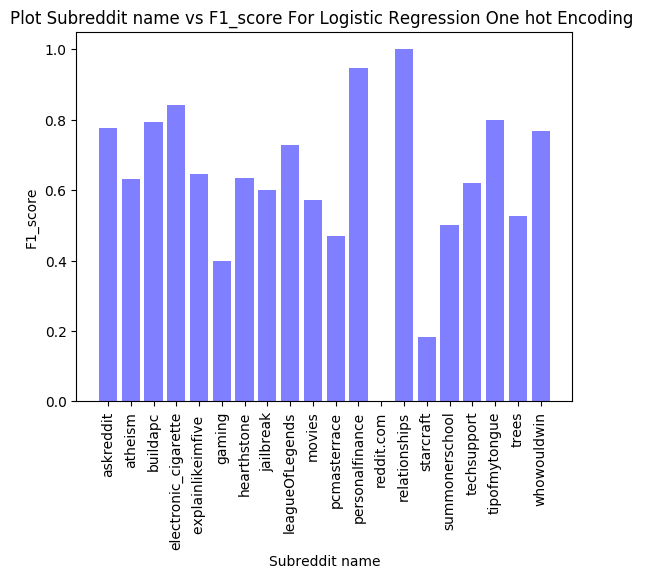

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
f1_score=[0.776,0.632,0.795,0.842,0.645,0.4,0.636,0.6,0.729,0.571,0.471,0.947,0,1,0.182,0.5,0.621,0.8,0.526,0.769]

subreddit=['askreddit', 'atheism','buildapc','electronic_cigarette',   'explainlikeimfive ','gaming','hearthstone','jailbreak','leagueOfLegends','movies','pcmasterrace',
'personalfinance','reddit.com','relationships','starcraft','summonerschool','techsupport','tipofmytongue','trees','whowouldwin']


print(len(subreddit), len(f1_score))
plt.bar(subreddit, f1_score, align='center', alpha=0.5,color='b')
plt.xticks(subreddit,  rotation='vertical')
plt.ylabel('F1_score')
plt.xlabel('Subreddit name')
plt.title('Plot Subreddit name vs F1_score For Logistic Regression One hot Encoding ')
 
plt.show()
 


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

## Question 2: Tuning Hyperparameters

### Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV
from random import shuffle, choices
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [0]:
from sklearn.model_selection import GridSearchCV
from random import shuffle, choices
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


pipeline =Pipeline([
    ('union', FeatureUnion([
        ('Body', Pipeline([
           ('selector',ItemSelector('Body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                    # sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        ('Author', Pipeline([
           ('selector',ItemSelector('Author')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                    #sublinear_tf=True,
                                    ngram_range=(1,1)
                                    )),
        
        ])),
        
         ('title', Pipeline([
           ('selector',ItemSelector('title')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     #sublinear_tf=True,
                                     ngram_range=(1,1)
                                    )),
             
         ])),
       
    ])),
    ('logit',LogisticRegression(solver='sag',multi_class='multinomial',C=10e4)),
                                    
        
])

parameters= {
#     'union__Body__tfidf__sublinear_tf':(True,False),
#     'union__title__tfidf__sublinear_tf':(True,False),
    #'union__Author__tfidf__sublinear_tf':(True,False),
    #'union__Body__tfidf__ngram_range':((1,1),(1,2)),
    #'union__title__tfidf__ngram_range':((1,1),(1,2)),
    #'union__Author__tfidf__ngram_range':((1,1),(1,2),(1,3)),
    #'union__Body__tfidf__max_features':(2500,7500,5000),
    #'union__title__tfidf__max_features':(None,3000,15000),
    #'union__Author__tfidf__max_features':(None,3000,15000),
    
#     'logit__solver':('newton-cg','lbfgs', 'sag'),
#     'logit__multi_class':('ovr','multinomial','auto'),
#     'logit__C':[10e-2,10, 10e1 , 10e2 , 10e3,10e4],    
    
    }

# grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
# print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
# print("parameters:")
# print(parameters)
# grid_search.fit(train_threads, train_labels)

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#   print("\t%s: %r" % (param_name, best_parameters[param_name]))


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 39.1min finished

Best score: 0.266


Best parameters set:

	union__Author__tfidf__ngram_range: (1, 1)
	union__Author__tfidf__sublinear_tf: TrueDone 278 out of 278| elapsed

	union__Body__tfidf__ngram_range: (1, 1)
	union__Body__tfidf__sublinear_tf: False
	union__title__tfidf__ngram_range: (1, 1)
	union__title__tfidf__sublinear_tf: True






Done 278 out of 278| elapsed: 58.4min finished

Best score: 0.298

Best parameters set:

union__Body__tfidf__max_features: 2500

union__title__tfidf__max_features: None

union__Author__tfidf__max_features: None

logit__solver:sag

logit__multi_class: multinomial

logit__C:10e4



In [0]:
#Confusion matrix
#source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    
    thresh =cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
classes=['askreddit','atheism','buildapc','electronic_cigarette','explainlikeimfive','gaming','hearthstone','jailbreak','leagueOfLegends','movies','pcmasterrace','personalfinance','reddit.com','relationships','starcraft','summonerschool','techsupport','tipofmytongue','trees','whowouldwin']



def evaluation_summary_grid(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  cm2=confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(7,7))
  plot_confusion_matrix(cm2, classes,title='Confusion matrix, without normalization')
  plt.show()
 # print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))

In [0]:
pipeline.fit(train_threads,train_labels)
prediction=pipeline.predict(test_threads)

evaluation_summary("After grid search", prediction,test_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: After grid search
Classifier 'After grid search' has Acc=0.723 P=0.626 R=0.698 F1=0.626
                      precision    recall  f1-score   support

           askreddit      0.869     0.676     0.760       108
             atheism      0.417     1.000     0.588         5
            buildapc      0.892     0.825     0.857        40
electronic_cigarette      0.889     0.727     0.800        11
   explainlikeimfive      0.714     0.588     0.645        17
              gaming      0.647     0.440     0.524        25
         hearthstone      0.600     1.000     0.750         9
           jailbreak      0.818     1.000     0.900         9
     leagueoflegends      0.833     0.816     0.825        49
              movies      0.200     0.500     0.286         2
        pcmasterrace      0.304     0.778     0.438         9
     personalfinance      0.900     0.818     0.857        11
          reddit.com      0.000     0.000     0.000         2
       relationships      1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
body = test_threads[np.logical_and(test_threads.subreddit == '', prediction == '')]
print(*body.Body, sep='\n -----------\n')

## Error Analysis

In [0]:
def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx]['Body'])
    

In [0]:
print_errors(test_labels, prediction, test_threads)

0 starcraft gaming Was watching a VOD from last years DreamHack Winter. The first map in the finals (Naama vs Mana) was Lost Temple.. spawning close ground positions..

It's a great sign that shows how much the game is evolving imo. Has anyone else noticed stuff like this?I find it cool that both Mana and Naama made it to the Ro16 in this DH Winter. Shows that they weren't just flashes in the pan.Even better, watch a VOD from [MLG Raleigh](http://tv.majorleaguegaming.com/videos/174-wr4-g2-kiwikaki-vs-nadagast-steppes-of-war-mlg-raleigh-starcraft-2)

The games, the casting, the maps... everything was fucking awful.  Amazing that it was just over one year ago.Wasn't that also an epic and awesome series? I remember it being one of the best series I had seen at that point.
9 hearthstone leagueoflegends So I meant to post this yesterday, but in one of my Arena games I noticed something I hadn't seen before. I was playing against a Priest and at around turn 7 he just gave up and spammed the 

## Feature Development

In [0]:
def getMajority(posts):
  arr= list()
   
  for post in posts:
    try:
      arr.append(post['majority_type'])
    except KeyError:
      pass
    
  return ''.join(map(str, arr))

def getPostDepth(posts):
  arr= list()
   
  for post in posts:
    try:
      arr.append(post['post_depth'])
    except KeyError:
      pass
    
  return ''.join(map(str, arr))

def getBodylen(Body):
  return str(len(Body))


In [0]:
train_threads['Majority_type']= train_threads.posts.apply(getMajority)
test_threads['Majority_type'] = test_threads.posts.apply(getMajority)

train_threads['Post_depth']= train_threads.posts.apply(getPostDepth)
test_threads['Post_depth'] = test_threads.posts.apply(getPostDepth)

train_threads['Bodylen'] = train_threads.Body.apply(getBodylen)
#print(train_threads.posts.iloc[0]
test_threads['Bodylen']=test_threads.Body.apply(getBodylen)


In [0]:
pipeline2 =Pipeline([
    ('union', FeatureUnion([
        ('Body', Pipeline([
           ('selector',ItemSelector('Body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        ('Author', Pipeline([
           ('selector',ItemSelector('Author')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                    sublinear_tf=True,
                                    ngram_range=(1,1)
                                    )),
        
        ])),
        
         ('title', Pipeline([
           ('selector',ItemSelector('title')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=True,
                                     ngram_range=(1,1)
                                    )),
             
         ])),
        ('Post_depth', Pipeline([
           ('selector',ItemSelector('Post_depth')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                      sublinear_tf=True,ngram_range=(1,1)
                                   )),
             
         ])),
#         ('Bodylen', Pipeline([
#            ('selector',ItemSelector('Bodylen')),
#            ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
#                                       sublinear_tf=True,ngram_range=(1,1)
#                                    )),
             
#          ])),
        
         ('Majority_type', Pipeline([
           ('selector',ItemSelector('Majority_type')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                      sublinear_tf=True,ngram_range=(1,1)
                                   )),
             
         ])),
    ])),
    ('logit',LogisticRegression(solver='saga',multi_class='multinomial',C=10e3)),
                                    
        
])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: After adding new features
Classifier 'After adding new features' has Acc=0.671 P=0.556 R=0.696 F1=0.576
                      precision    recall  f1-score   support

           askreddit      0.881     0.597     0.712       124
             atheism      0.417     1.000     0.588         5
            buildapc      0.892     0.805     0.846        41
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.929     0.650     0.765        20
              gaming      0.294     0.263     0.278        19
         hearthstone      0.467     1.000     0.636         7
           jailbreak      0.636     0.778     0.700         9
     leagueoflegends      0.812     0.709     0.757        55
              movies      0.000     0.000     0.000         1
        pcmasterrace      0.261     0.750     0.387         8
     personalfinance      0.800     0.889     0.842         9
          reddit.com      0.000     0.000     0.000         1
       rela

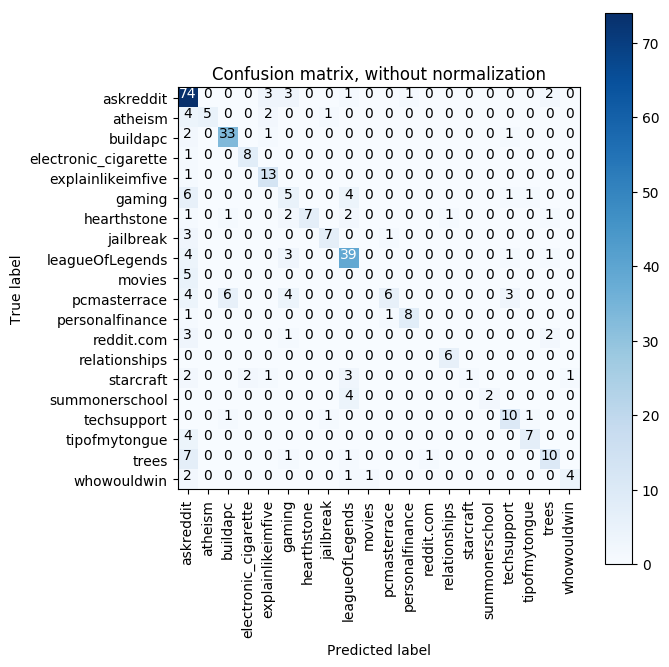

In [0]:
pipeline2.fit(train_threads,train_labels)
prediction2=pipeline2.predict(test_threads)

evaluation_summary_grid("After adding new features", prediction2,test_labels)

# Part B: Discourse prediction ##

In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.
import pandas as pd
import json

def load_posts(file):
  # A temporary variable to store the list of post content.
  posts_tmp = list()

  with open(file) as jsonfile:
    for i, line in enumerate(jsonfile):
     # if (i > 2): break
      thread = json.loads(line)
      for post in thread['posts']:
        # NOTE: This could be changed to use additional features from the post or thread.
        # DO NOT change the labels for the test set.
        posts_tmp.append((thread['subreddit'], thread['title'], thread['url'], thread['is_self_post'],
                        post['id'], post.get('author', ""), post.get('body', ""), post.get("majority_link", ""), 
                        post.get('post_depth', 0), post.get('majority_type', ""), # discourse type label 
                        post.get('in_reply_to', "") ))

# Create the posts data frame.  
  labels = ['subreddit', 'title', 'url','is_self_post', 'id', 'author', 'body', 'majority_link', 
          'post_depth', 'discourse_type', 'in_reply_to']
  return pd.DataFrame(posts_tmp, columns=labels)

In [0]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

Copying gs://textasdata/coursework/coursework_discourse_train.json...
- [1 files][ 60.2 MiB/ 60.2 MiB]                                                
Operation completed over 1 objects/60.2 MiB.                                     
Copying gs://textasdata/coursework/coursework_discourse_test.json...
/ [1 files][ 15.1 MiB/ 15.1 MiB]                                                
Operation completed over 1 objects/15.1 MiB.                                     


### Load train data

In [0]:
train_posts = load_posts(discourse_train)
# Filter out empty labels
train_posts = train_posts[train_posts['discourse_type'] != ""]
train_posts.head(20)
print("Num posts: ", train_posts.size)

Num posts:  871937


In [0]:
print(train_posts.head(20))
  
#print(train_posts.num_comment.iloc[9999:11200])

     subreddit                           title  \
0   worldofpvp  Help me decide my new PvP main   
1   worldofpvp  Help me decide my new PvP main   
2   worldofpvp  Help me decide my new PvP main   
3   worldofpvp  Help me decide my new PvP main   
4   worldofpvp  Help me decide my new PvP main   
5   worldofpvp  Help me decide my new PvP main   
6   worldofpvp  Help me decide my new PvP main   
7        anime         Anime so bad it's good?   
8        anime         Anime so bad it's good?   
9        anime         Anime so bad it's good?   
10       anime         Anime so bad it's good?   
11       anime         Anime so bad it's good?   
12       anime         Anime so bad it's good?   
13       anime         Anime so bad it's good?   
14       anime         Anime so bad it's good?   
15       anime         Anime so bad it's good?   
16       anime         Anime so bad it's good?   
17       anime         Anime so bad it's good?   
18       anime         Anime so bad it's good?   


The label for the post we will be predicting is in the discourse_type column.

### Load test data

In [0]:
test_posts = load_posts(discourse_test)
# Filter out empty labels
test_posts = test_posts[test_posts['discourse_type'] != ""]
print("Num posts: ", test_posts.size)


Num posts:  217932


### Label distribution

In [0]:
train_labelsB = train_posts.discourse_type
test_labelsB = test_posts.discourse_type

Examine the distribution over labels on the training data.

In [0]:
discourse_counts = train_labelsB.value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(200)
print(top_discourse)
top_discourse = top_discourse.index.tolist()
print(top_discourse)

count       10.000000
mean      7926.700000
std       9664.321866
min       1266.000000
25%       1671.500000
50%       3235.500000
75%      11919.750000
max      31419.000000
Name: discourse_type, dtype: float64
answer              31419
elaboration         14775
question            13610
appreciation         6849
agreement            3868
disagreement         2603
humor                1787
other                1633
announcement         1457
negativereaction     1266
Name: discourse_type, dtype: int64
['answer', 'elaboration', 'question', 'appreciation', 'agreement', 'disagreement', 'humor', 'other', 'announcement', 'negativereaction']


## Question 3


###  Logistic regression TF-IDF Vectorisation

In [0]:
classesB=['agreement','announcement','answer','appreciation','disagreement','elaboration','humor','negativereaction','other','question']     

     
def evaluation_summary_gridB(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  cm2=confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(cm2, classesB,title='Confusion matrix, without normalization')
  plt.show()
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Evaluation for: LR tfidf


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Classifier 'LR tfidf' has Acc=0.512 P=0.235 R=0.410 F1=0.245


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                  precision    recall  f1-score   support

       agreement      0.201     0.552     0.295       346
    announcement      0.000     0.000     0.000         0
          answer      0.854     0.500     0.631     13563
    appreciation      0.604     0.760     0.673      1368
    disagreement      0.016     0.278     0.030        36
     elaboration      0.136     0.306     0.188      1615
           humor      0.009     0.333     0.017        12
negativereaction      0.026     0.400     0.049        20
           other      0.032     0.400     0.059        30
        question      0.468     0.568     0.513      2822

       micro avg      0.512     0.512     0.512     19812
       macro avg      0.235     0.410     0.245     19812
    weighted avg      0.708     0.512     0.572     19812

Confusion matrix, without normalization
[[ 191    0  518   43    5  111    2    1    0   80]
 [   2    0  299    6    0   23    0    0    0   35]
 [  58    0 6780   98    4  504    0   

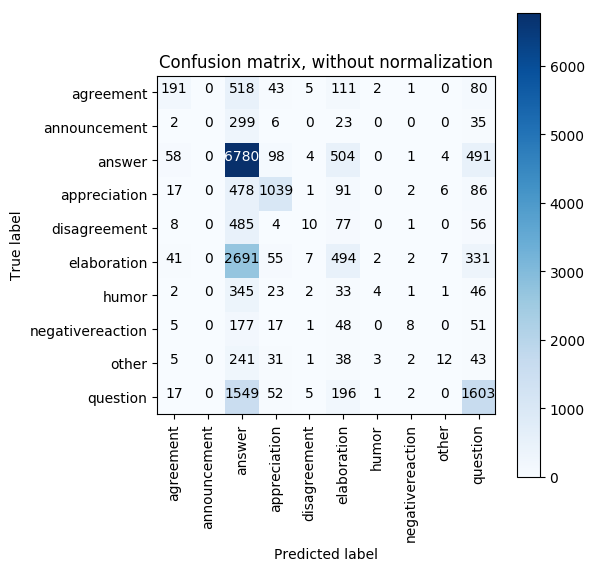

In [0]:
# Define the features

Tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,binary=True)
X_train =Tfidf_vectorizer.fit_transform(train_posts['body'])
X_test = Tfidf_vectorizer.transform(test_posts['body'])

classifier = LogisticRegression()
nb_model = classifier.fit(X_train, train_labelsB)
predicted_label_lr = nb_model.predict(X_test)
evaluation_summary_gridB("LR tfidf",  predicted_label_lr, test_labelsB)


## Error Analysis

In [0]:
def print_errors(labels, predictions, data):
  label_arr = labels.values
  for idx, prediction in enumerate(predictions): 
    label = label_arr[idx]
    if prediction != label:
      print(idx, label, prediction, data.iloc[idx]['body'])

In [0]:
print_errors(test_labelsB,  predicted_label_lr, test_posts)

0 question appreciation Edit: I'm in the Oklahoma City and Tulsa Oklahoma area BTW, and thanks for everyone's input!
1 question answer are you in the USA?  i would say that unless the road says "no stopping unless emergency" or something then you are good to go.  that being said, fully expect a cop to stop and harass you about it.

i moved (from the US) to new zealand and stopped on the side of the desert highway (where you can see Mt Doom from LotR) to take some photos at night, a cop stopped, turned around, and came... and asked if i needed help!  ah, kiwi land =)
2 answer question [deleted]
3 appreciation elaboration Great info! It shows that stopping on a highway should be taken seriously. Those rules were made for a reason. Even tow truck drivers need special certification to work on the side of the highway. Cars and semis are travelling fast and drivers are in a groove. Not to mention at night there will be people dosing and drifting onto the curb. 

I've stopped at night for int

## Question 4:

## Adding 7 new Features:

## 1.  Meta Data: is a self post

In [0]:
#function to create is_self column
def create_is_self_post(x):
    if x == 1.0:
        return 1 # 'positive' 
    return 0 # 'negative' for Nan values and empty values
  
train_posts['is_self'] = train_posts.is_self_post.apply(create_is_self_post)
test_posts['is_self']=test_posts.is_self_post.apply(create_is_self_post)

### Evaluation 

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [0]:
from sklearn.preprocessing import StandardScaler

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [0]:
from sklearn.model_selection import GridSearchCV
from random import shuffle, choices
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


pipeline =Pipeline([
    ('union', FeatureUnion([
        ('body', Pipeline([
           ('selector',ItemSelector('body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        
         ('is_selected', Pipeline([
               ('selector', NumberSelector(key='is_self')),
               ('standard', StandardScaler()), 
               ])),
       
    ])),
        
   
    ('logit',LogisticRegression(solver='sag',multi_class='multinomial',C=10e4)),
                                    
        
])

In [0]:
pipeline.fit(train_posts,train_labelsB)
prediction=pipeline.predict(test_posts)

evaluation_summary("After grid search", prediction,test_labelsB)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Evaluation for: After grid search
Classifier 'After grid search' has Acc=0.489 P=0.258 R=0.314 F1=0.273
                  precision    recall  f1-score   support

       agreement      0.249     0.408     0.309       581
    announcement      0.038     0.075     0.051       187
          answer      0.765     0.527     0.625     11525
    appreciation      0.595     0.658     0.625      1557
    disagreement      0.078     0.192     0.111       260
     elaboration      0.172     0.280     0.213      2231
           humor      0.055     0.138     0.078       181
negativereaction      0.091     0.151     0.114       186
           other      0.072     0.172     0.101       157
        question      0.464     0.540     0.499      2947

       micro avg      0.489     0.489     0.489     19812
       macro avg      0.258     0.314     0.273     19812
    weighted avg      0.591     0.489     0.524     19812


Confusion matrix:
 [[ 237    5  411   62   14  124   10   10    3   75]
 [   1  

## 2. Thread Features: the total number of comments in the discussion
 

In [0]:
import numpy as np
#create a column called comment
#get total number of comments for all the threads in the train_posts

title=np.unique(train_posts['title'])
len(title)

dict={}
dict2={}
for x in title:
  
  dict[x]=len(train_posts[train_posts['title']==x])

  
train_posts['num_comment'] = train_posts['title'].apply(lambda x: dict.get(x))



In [0]:
title=np.unique(test_posts['title'])
len(title)

for x in title:
  
  dict[x]=len(test_posts[test_posts['title']==x])

test_posts['num_comment'] = test_posts['title'].apply(lambda x: dict.get(x))


### Evaluation

In [0]:
pipeline =Pipeline([
    ('union', FeatureUnion([
        ('body', Pipeline([
           ('selector',ItemSelector('body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        
         ('num_comment', Pipeline([
               ('selector', NumberSelector(key='num_comment')),
               ('standard', StandardScaler()), 
               ])),
       
    ])),
        
   
    ('logit',LogisticRegression(solver='saga',multi_class='multinomial',C=10e4)),
                                    
        
])

pipeline.fit(train_posts,train_labelsB)
prediction=pipeline.predict(test_posts)

evaluation_summary("After grid search", prediction,test_labelsB)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Evaluation for: After grid search
Classifier 'After grid search' has Acc=0.485 P=0.255 R=0.315 F1=0.269
                  precision    recall  f1-score   support

       agreement      0.249     0.399     0.307       594
    announcement      0.047     0.149     0.071       114
          answer      0.757     0.513     0.612     11701
    appreciation      0.591     0.661     0.624      1536
    disagreement      0.073     0.185     0.105       254
     elaboration      0.167     0.288     0.211      2111
           humor      0.037     0.102     0.055       166
negativereaction      0.085     0.133     0.104       195
           other      0.074     0.177     0.105       158
        question      0.469     0.538     0.501      2983

       micro avg      0.485     0.485     0.485     19812
       macro avg      0.255     0.315     0.269     19812
    weighted avg      0.591     0.485     0.521     19812


Confusion matrix:
 [[ 237    3  415   57   16  125   12   12    3   71]
 [   3  

## Structure: the number of words in a post

In [0]:
train_posts['length'] = train_posts['body'].apply(lambda x: len(str(x).split(" ")))
test_posts['length'] = test_posts['body'].apply(lambda x: len(str(x).split(" ")))

### Evaluation

In [0]:
pipeline =Pipeline([
    ('union', FeatureUnion([
        ('body', Pipeline([
           ('selector',ItemSelector('body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        
         ('length', Pipeline([
               ('selector', NumberSelector(key='length')),
               ('standard', StandardScaler()), 
               ])),
       
    ])),
        
   
    ('logit',LogisticRegression(solver='saga',multi_class='multinomial',C=10e4)),
                                    
        
])

pipeline.fit(train_posts,train_labelsB)
prediction=pipeline.predict(test_posts)

evaluation_summary("After grid search", prediction,test_labelsB)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Evaluation for: After grid search


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Classifier 'After grid search' has Acc=0.506 P=0.221 R=0.360 F1=0.229


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                  precision    recall  f1-score   support

       agreement      0.163     0.592     0.256       262
    announcement      0.047     0.500     0.085        34
          answer      0.879     0.489     0.628     14272
    appreciation      0.565     0.749     0.644      1296
    disagreement      0.002     0.083     0.003        12
     elaboration      0.105     0.305     0.156      1252
           humor      0.000     0.000     0.000         0
negativereaction      0.000     0.000     0.000         0
           other      0.013     0.312     0.026        16
        question      0.440     0.564     0.494      2668

       micro avg      0.506     0.506     0.506     19812
       macro avg      0.221     0.360     0.229     19812
    weighted avg      0.738     0.506     0.575     19812


Confusion matrix:
 [[ 155    0  558   42    1  117    0    0    0   78]
 [   0   17  291    9    0   10    0    0    0   38]
 [  45    3 6979   87    3  354    0    0    4  465]
 [  11

 for split by \n Classifier 'After grid search' has Acc=0.457 P=0.161 R=0.309 F1=0.155
 
 for split by space Classifier 'After grid search' has Acc=0.506 P=0.222 R=0.360 F1=0.229

## 4. Author: A binary feature for whether the current author is also the author of the initial post

In [0]:
import numpy as np

train_posts['same_author']=np.where(np.logical_or(train_posts['author']==train_posts['in_reply_to'] , train_posts['in_reply_to']=='') ,1,0)
test_posts['same_author']=np.where(np.logical_or(test_posts['author']==test_posts['in_reply_to'] , test_posts['in_reply_to']=='') ,1,0)

#train_posts#==train_posts['in_reply_to']

### Evaluation

In [0]:
pipeline =Pipeline([
    ('union', FeatureUnion([
        ('body', Pipeline([
           ('selector',ItemSelector('body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        
         ('same_author', Pipeline([
               ('selector', NumberSelector(key='same_author')),
               ('standard', StandardScaler()), 
               ])),
       
    ])),
        
   
    ('logit',LogisticRegression(solver='saga',multi_class='multinomial',C=10e4)),
                                    
        
])

pipeline.fit(train_posts,train_labelsB)
prediction=pipeline.predict(test_posts)

evaluation_summary("After grid search", prediction,test_labelsB)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Evaluation for: After grid search
Classifier 'After grid search' has Acc=0.530 P=0.299 R=0.374 F1=0.319
                  precision    recall  f1-score   support

       agreement      0.253     0.418     0.316       576
    announcement      0.288     0.455     0.352       231
          answer      0.797     0.544     0.647     11633
    appreciation      0.605     0.674     0.638      1542
    disagreement      0.069     0.184     0.100       239
     elaboration      0.172     0.306     0.221      2048
           humor      0.033     0.109     0.051       137
negativereaction      0.091     0.169     0.118       166
           other      0.088     0.219     0.125       151
        question      0.594     0.659     0.625      3089

       micro avg      0.530     0.530     0.530     19812
       macro avg      0.299     0.374     0.319     19812
    weighted avg      0.639     0.530     0.567     19812


Confusion matrix:
 [[ 241    0  439   56   15  131   10   11    2   46]
 [   0  

In [0]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class AverageEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.dimension = 300
        
    def fit(self, X, y):
        return self
      
    def transform(self, X):  
      # Skip OOV terms. 
      # Return 0 for all dimensions if no words are in the vocabulary.
      dense_matrix =  np.array([ 
          np.mean([token.vector for token in self.tokenizer(doc) if not token.is_oov]
                or [np.zeros(self.dimension)], axis=0)
          for doc in X
      ])
      return dense_matrix

In [0]:
# Note: We don't call fit here because it doesn't do anything.
embedding_vectorizer = AverageEmbeddingTransformer(spacy_tokenize)
train_embedding_features = embedding_vectorizer.transform(train_posts['body'])
#validation_embedding_features = embedding_vectorizer.transform(validation_data['reviewText'])
test_embedding_features = embedding_vectorizer.transform(test_posts['body'])

In [0]:
lr_w2v = LogisticRegression(solver = 'saga', verbose=1)
lr_w2v_model = lr_w2v.fit(train_embedding_features, train_labelsB)
evaluation_summary_gridB("LR W2V", lr_w2v_model.predict(test_embedding_features), test_labelsB)

In [0]:
from scipy.sparse import csr_matrix
train_sparse_embeddings = csr_matrix(train_embedding_features)
test_sparse_embeddings = csr_matrix(test_embedding_features)
type(test_sparse_embeddings)

In [0]:
## Solution 
from scipy import sparse
X_train = sparse.hstack([one_hot_train_features,train_embedding_features])
X_test = sparse.hstack([one_hot_validation_features,test_sparse_embeddings])


In [0]:
combined_lr = LogisticRegression(solver='saga')
combined_lr_model = combined_lr.fit(X_train, train_labelsB)
evaluation_summary_gridB("LR w/ W2V", combined_lr_model.predict(X_test), test_labelsB)

### community: The subreddit the post came from

In [0]:
pipeline =Pipeline([
    ('union', FeatureUnion([
        ('body', Pipeline([
           ('selector',ItemSelector('body')),
           ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize,
                                     sublinear_tf=False,
                                    max_features=2500, ngram_range=(1,1)
                                    )),
                                    
        ])),
        
           ('subreddit', Pipeline([
              ('selector', ItemSelector(key='subreddit')),
              ('tf-hot', TfidfVectorizer(tokenizer=tokenize_normalize,lowercase=True)), 
              ])),
       
    ])),
        
   
    ('logit',LogisticRegression(solver='saga',multi_class='multinomial',C=10e4)),
                                    
        
])

pipeline.fit(train_posts,train_labelsB)
prediction=pipeline.predict(test_posts)

evaluation_summary("After grid search", prediction,test_labelsB)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: After grid search
Classifier 'After grid search' has Acc=0.466 P=0.260 R=0.289 F1=0.269
                  precision    recall  f1-score   support

       agreement      0.236     0.330     0.275       678
    announcement      0.082     0.109     0.094       274
          answer      0.703     0.525     0.601     10632
    appreciation      0.567     0.612     0.589      1596
    disagreement      0.081     0.146     0.104       356
     elaboration      0.185     0.285     0.224      2357
           humor      0.081     0.119     0.096       310
negativereaction      0.088     0.102     0.094       265
           other      0.112     0.130     0.120       322
        question      0.467     0.529     0.496      3022

       micro avg      0.466     0.466     0.466     19812
       macro avg      0.260     0.289     0.269     19812
    weighted avg      0.531     0.466     0.490     19812


Confusion matrix:
 [[ 224    5  379   64   19  133   17   17   18   75]
 [   5  

## All the features combined

In [0]:
prediction_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-hot', TfidfVectorizer(tokenizer=tokenize_normalize, ngram_range=(1,1),lowercase=True)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf-hot', TfidfVectorizer(tokenizer=tokenize_normalize, ngram_range=(1,1),lowercase=True)), 
              ])),
              
            ('subreddit', Pipeline([
              ('selector', ItemSelector(key='subreddit')),
              ('tf-hot', TfidfVectorizer(tokenizer=tokenize_normalize,lowercase=True)), 
              ])),
              
            ('length', Pipeline([
              ('selector', NumberSelector(key='length')),
              ('standard', StandardScaler()), 
              ])),
              
            ('same_author', Pipeline([
                ('selector', NumberSelector(key='same_author')),
                ('standard', StandardScaler()), 
                ])),
             ('depth', Pipeline([
               ('selector', NumberSelector(key='post_depth')),
               ('standard', StandardScaler()), 
               ])),
              
             ('comments', Pipeline([
               ('selector', NumberSelector(key='num_comment')),
               ('standard', StandardScaler()), 
               ])),
              
            
             ('is_selected', Pipeline([
               ('selector', NumberSelector(key='is_self')),
               ('standard', StandardScaler()), 
               ])),
              
        ])),
         
   
         ('logit',LogisticRegression(solver='sag',multi_class='multinomial',C=10e4)),
      
       
    ])



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by Standard

Evaluation for: After grid search
Classifier 'After grid search' has Acc=0.592 P=0.318 R=0.504 F1=0.341
                  precision    recall  f1-score   support

       agreement      0.178     0.526     0.266       321
    announcement      0.499     0.743     0.597       245
          answer      0.864     0.601     0.709     11422
    appreciation      0.585     0.778     0.668      1293
    disagreement      0.023     0.250     0.043        60
     elaboration      0.400     0.399     0.399      3642
           humor      0.020     0.290     0.037        31
negativereaction      0.013     0.571     0.025         7
           other      0.005     0.154     0.010        13
        question      0.591     0.729     0.653      2778

       micro avg      0.592     0.592     0.592     19812
       macro avg      0.318     0.504     0.341     19812
    weighted avg      0.702     0.592     0.629     19812

Confusion matrix, without normalization
[[ 169    0  428   43    4  265    0    0

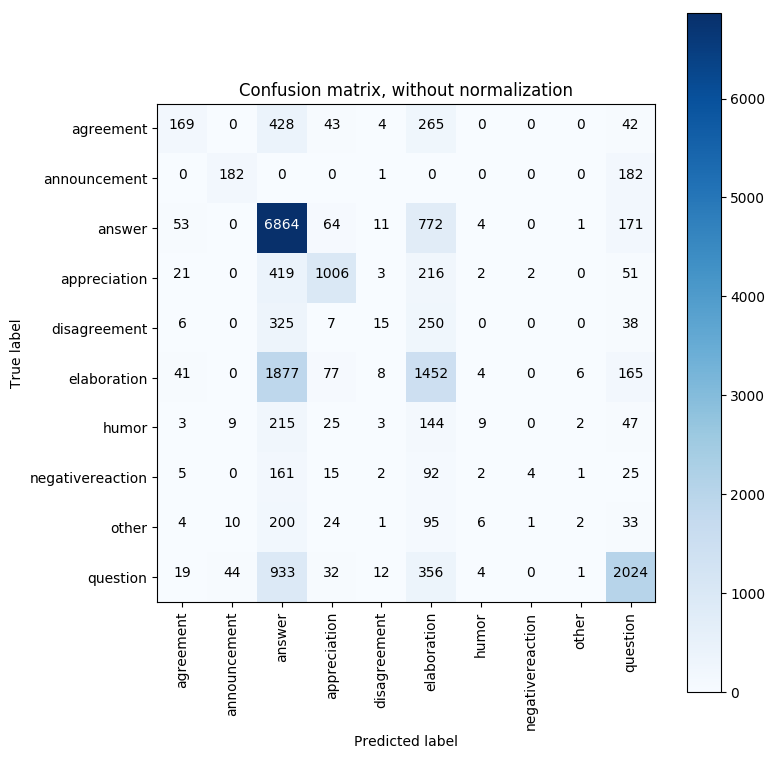

In [0]:
prediction_pipeline.fit(train_posts,train_labelsB)
prediction=prediction_pipeline.predict(test_posts)

evaluation_summary_gridB("After grid search", prediction,test_labelsB)

In [0]:
X_trainB = prediction_pipeline.fit_transform(train_posts)
X_testB = prediction_pipeline.transform(test_posts)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation for: After grid search


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Classifier 'After grid search' has Acc=0.577 P=0.268 R=0.412 F1=0.288


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                  precision    recall  f1-score   support

       agreement      0.038     0.667     0.072        54
    announcement      0.323     0.776     0.456       152
          answer      0.894     0.572     0.698     12401
    appreciation      0.467     0.845     0.602       951
    disagreement      0.002     0.091     0.003        11
     elaboration      0.389     0.375     0.382      3766
           humor      0.000     0.000     0.000         1
negativereaction      0.000     0.000     0.000         0
           other      0.000     0.000     0.000         0
        question      0.571     0.789     0.662      2476

       micro avg      0.577     0.577     0.577     19812
       macro avg      0.268     0.412     0.288     19812
    weighted avg      0.730     0.577     0.625     19812

Confusion matrix, without normalization
[[  36    0  542   29    0  320    0    0    0   24]
 [   0  118    0    0    5    0    0    0    0  242]
 [   8    0 7099   29    0  735    1   

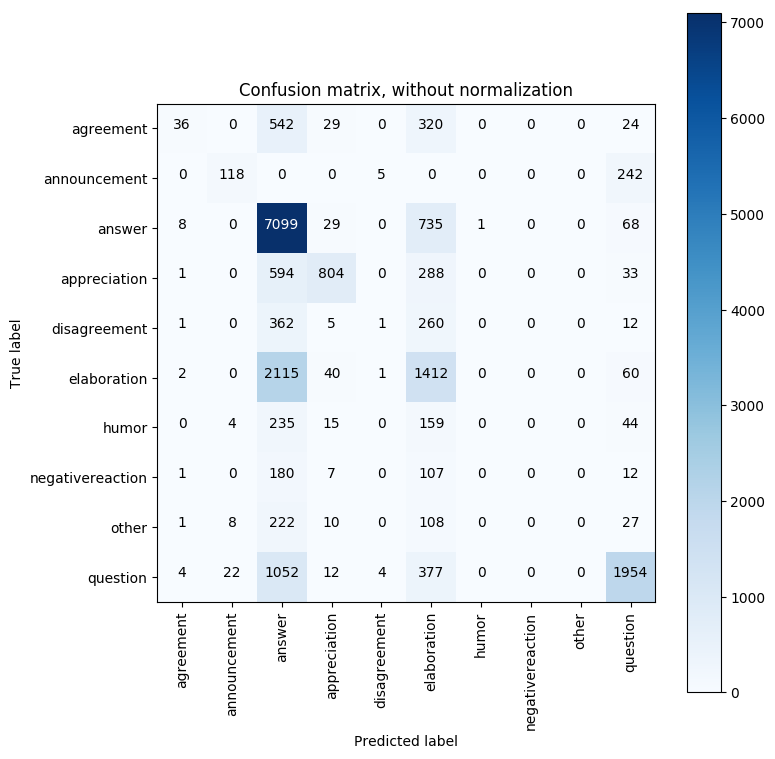

In [0]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(multi_class='multinomial',solver='saga')
lr.fit(X_trainB, train_labelsB)
predictions = lr.predict(X_testB)
evaluation_summary_gridB("After grid search", predictions,test_labelsB)

In [0]:
prediction_pipeline.fit(train_posts,train_labelsB)
prediction=prediction_pipeline.predict(test_posts)

evaluation_summary_gridB("After grid search", prediction,test_labelsB)

## creating a graph of top 20 features

In [0]:
!pip install eli5

    100% |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
from IPython.display import display
import eli5
eli5.show_weights(lr,vec=prediction_pipeline,top=20)

In [0]:
#import itertools 
#Tokenized_train_posts = train_posts.body.apply(tokenize_normalize)

#all_tokens = list(itertools.chain.from_iterable(Tokenized_train_posts))
#print("Num tokens: ", len(all_tokens))